In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.utils.data as data_utils
from torch.autograd import Variable
import pickle
from sklearn.model_selection import train_test_split
import math
import os           
import re
import collections
from functools import partial
from torch import optim
from torchsummary import summary
from efficientnet import EfficientNet
from Radam import RAdam
import random
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import plotnine as p9

In [6]:
torch.cuda.is_available()

False

In [7]:
allele = 'phospho-B-15'
model = EfficientNet.from_name(f'efficientnet-{allele}')
model = nn.DataParallel(model)
#model.load_state_dict(torch.load('/home/geonwon/Code/saved_model2/'
#                                         'Efficientnet_1_kernel_3_ms_only_same_ratio'
#                                         '/best_23.pth'
#                                         )['state_dict'])
model.eval()

efficientnet-phospho-B-15


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 8, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(8, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          8, 8, kernel_size=(3, 3), stride=[1, 1], groups=8, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(8, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          8, 2, kernel_size=(3, 3), stride=(1, 1)
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_se_expand): Conv2dStaticSamePadding(
          2, 8, kernel_size=(3, 3), stride=(1, 1)
          (static_padding): ZeroPad

In [8]:
criterion = nn.BCELoss()
optimizer = RAdam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

#Writer will output to ./runs/ directory by default
save_dir = f'saved_test_model/Efficientnet_{allele}_kernel_3_ms_only_same_ratio'
writer = SummaryWriter(save_dir)

In [9]:
def precision_recall(y_true, y_pred):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    #assert y_true.ndim == 1
    #assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    #if y_pred.ndim == 2:
    #    y_pred = y_pred.argmax(dim=1)

    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    
    f1 = 2 * (precision*recall) / (precision + recall +epsilon)

    
    
    return precision, recall, f1

In [10]:
def get_tpr(y_true,y_scores,threshold):
    predict_positive_num = len(y_scores[y_scores >= threshold]) 
    tp = len([x for x in y_true[:predict_positive_num] if x == 1])
    ground_truth = len(y_true[y_true==1]) 
    tpr =  tp / ground_truth
    return tpr
    
def get_fpr(y_true,y_scores,threshold):
    predict_positive_num = len(y_scores[y_scores >= threshold] )
    fp = len([x for x in y_true[:predict_positive_num] if x == 0 ])
    ground_negative = len(y_true[y_true==0])
    fpr = fp / ground_negative
    return fpr

In [11]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score
from tqdm import tqdm_notebook
from tqdm.notebook import tnrange, tqdm
import time

def test_model(model, optimizer, scheduler, num_epochs=200):
    global best_acc
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cuda:2")
    since = time.time()

    best_model_wts = model.state_dict()
    best_loss = 1000.0
    best_acc = 0
    
    if torch.cuda.device_count() > 1:
        print("Testing on ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model.to(device)
    #criterion.to(device)
    model.eval()
    
    for epoch in tqdm(range(num_epochs)):
        print('-' * 60)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))  
        
        # Test step
        global fprs,tprs, thresholds, Truedata, Scoredata, Lossdata
        test_loss = 0.0
        test_corrects = 0.0
        test_precision, test_recall, test_f1 = 0.0, 0.0, 0.0
        Truedata, Scoredata , Lossdata= [],[],[]
        fprs, tprs,thresholds = 0.0, 0.0, 0.0
        model.train(False)
        
        for data in tqdm(dataloaders['test']):
             # get the inputs
            inputs, labels = data
            #inputs = Variable(inputs.to(device, dtype=torch.float))
            #labels = Variable(labels.to(device))
            inputs = inputs.to(device, dtype=torch.float32).clone().detach()
            labels = labels.to(device).clone().detach()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)

            #_, preds = torch.max(outputs.data, 1)
            #loss = F.binary_cross_entropy(outputs, labels.float().view(-1,1)).to(device)
            #loss = F1_Loss(labels.float().view(-1,1).cpu(), outputs.cpu())
                
            precision, recall, f1= precision_recall(labels.float().view(-1,1).cpu(), outputs.cpu())
            loss = criterion(outputs, labels.float().view(-1,1)).to(device)


            # statistics
        
            test_loss += loss.data
            test_precision += precision.data
            test_recall += recall.data
            test_f1 += f1.data
            
            preds = (outputs>=0.5).float()
            #test_precision += precision_score(labels.cpu(), preds.cpu())
            #test_recall += recall_score(labels.cpu(), preds.cpu())
            #test_f1 += f1_score(labels.cpu(), preds.cpu())
            test_corrects += accuracy_score(labels.cpu(), preds.cpu())
            Truedata.extend(labels.cpu().numpy())
            Scoredata.extend(outputs.detach().cpu().numpy())
            
            
            
        fprs, tprs, thresholds = roc_curve(Truedata, Scoredata)
        Test_auc_score = roc_auc_score(Truedata, Scoredata)
#       Test_f1_score = f1_score(Truedata, Scoredata)

        epoch_test_loss = test_loss / dataset_sizes['test']
        epoch_test_precision = test_precision /dataset_sizes['test']
        epoch_test_recall = test_recall /dataset_sizes['test']
        epoch_test_f1 = test_f1 /dataset_sizes['test']
        epoch_test_acc = test_corrects / dataset_sizes['test']





        writer.add_scalars('Loss' , {'test':epoch_test_loss}, epoch)
        writer.add_scalars('Accuracy' , {'test':epoch_test_acc},  epoch)
        writer.add_scalars('F1' , {'test':epoch_test_f1},  epoch)
        writer.add_scalars('precision' , {'test':epoch_test_precision},  epoch)
        writer.add_scalars('recall' , {'test':epoch_test_recall},  epoch)


        print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f} recall: {:.4f} AUC: {:.4f}' .format(
            'test', epoch_test_loss, epoch_test_acc, epoch_test_f1,epoch_test_recall,Test_auc_score))
        
        # deep copy the model
        if  epoch_test_loss < best_loss:
            best_loss = epoch_test_loss
            best_model_wts = model.state_dict()
            # save
            checkpoint = {'model': model,
                      #'state_dict': model.module.state_dict(),
                          'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

            savePath = "{}/best_{}.pth".format(save_dir, epoch+1)
            torch.save(checkpoint, savePath)
        else:
            # save
            checkpoint = {'model': model,
                      #'state_dict': model.module.state_dict(),
                          'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

            savePath = "{}/{}.pth".format(save_dir, epoch+1)
            torch.save(checkpoint, savePath)


        print('-' * 60)
        print()         
    
    plt.show()
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Loss: {:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
Total = [Scoredata,Truedata]

In [20]:
# save
with open('EffnetTotal.pickle', 'wb') as f:
    pickle.dump(Total, f, pickle.HIGHEST_PROTOCOL)

# load
with open('EffnetTotal.pickle', 'rb') as f:
    Total = pickle.load(f)

In [14]:
#df6.type.value_counts()

S    215
Y    137
T     39
C      1
V      1
A      1
Name: type, dtype: int64

(788, 1, 336, 15)
efficientnet-phospho-B-15


  0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/1


  0%|          | 0/788 [00:00<?, ?it/s]

test Loss: 0.6488 Acc: 0.6777 F1: 0.3679 recall: 0.3176 AUC: 0.7422
------------------------------------------------------------

Test complete in 0m 7s
Best test Loss: 0.648786


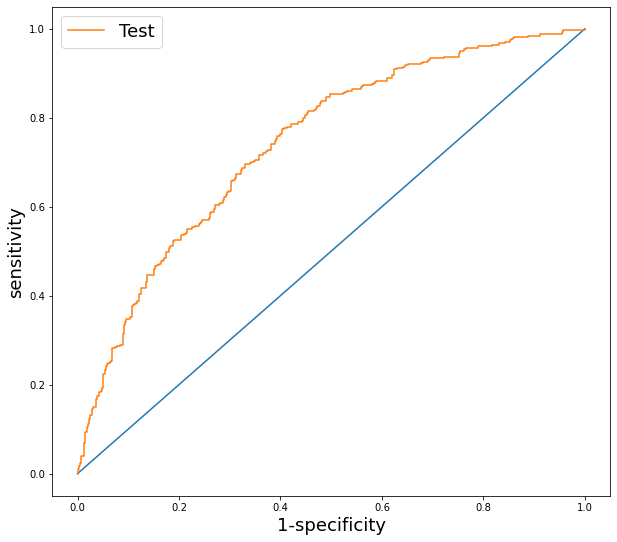

In [12]:
with open( "/home/geonwon/Code/databasetocuration/dfdepodhmmkinsub.pickle", "rb" ) as file:
    df6 = pickle.load(file)

import pandas as pd
df7 = pd.DataFrame(df6,columns=['index','KINseq','SITE_+/-7_AA','type',
                                'matrix'])

with open( "/home/geonwon/Code/databasetocuration/dfdepodhmm_ratiorandomver3.pickle", "rb" ) as file:
    df6 = pickle.load(file)

df6.rename(columns = {'kinseq' : 'KINseq','Substrate' : 'SITE_+/-7_AA'}, inplace = True)

df6 = df6[['KINseq','SITE_+/-7_AA','matrix']]
df7 = df7[['KINseq','SITE_+/-7_AA','matrix']]

df6 = df6[:394]
df6['answer'] = 1
df6['type'] = df6['SITE_+/-7_AA'].apply(lambda x:x[7])
df7['answer'] = 0
df7['type'] = df7['SITE_+/-7_AA'].apply(lambda x:x[7])

random_state=1004
df8 = df7[df7['type']=='S'].sample(n=216,random_state=random_state)

df9 = df7[df7['type']=='T'].sample(n=138,random_state=random_state)

df10 = df7[df7['type']=='Y'].sample(n=40,random_state=random_state)

df11 = pd.concat([df6,df8,df9,df10])




dfr1 = []
dfl1 = []
for i in df11['matrix']:
    dfr1.append(i)
for i in df11['answer']:
    dfl1.append(i)
dfr1 ,dfl1= np.array(dfr1),np.array(dfl1)
dfl1 = dfl1.reshape(788,1)
print(dfr1.shape)
dfl1.shape
xTest, yTest = dfr1, dfl1

#batch_size = 1인 경우
allele = 'phospho-B-15'
model = EfficientNet.from_name(f'efficientnet-{allele}')
model = nn.DataParallel(model)
#model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004_human/saved_model2/'
#                                           'Efficientnet_2_kernel_3_ms_only_same_ratio'
#                                           '/best_12.pth'
#                                            ,map_location=torch.device('cpu'))['state_dict'])#최고성능6802/7393
#model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004_human/saved_model3/'
#                                          'Efficientnet_0_kernel_3_ms_only_same_ratio'
#                                          '/best_44.pth'
#                                          ,map_location=torch.device('cpu'))['state_dict'])#최고성능
# model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004_human/saved_model4/'
#                                           'Efficientnet_1_kernel_3_ms_only_same_ratio'
#                                           '/best_44.pth'
#                                           ,map_location=torch.device('cpu'))['state_dict'])#최고성능6777/7422
# model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004_human/saved_model5/'
#                                          'Efficientnet_1_kernel_3_ms_only_same_ratio'
#                                          '/best_44.pth'
#                                          ,map_location=torch.device('cpu'))['state_dict'])#최고성능
model.eval()

BATCH_SIZE = 1

test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= True)

    
dataloaders = {'test':test_loader}
dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
model = test_model(model, optimizer, scheduler, 1) 

plt.figure(figsize=[10,9])
plt.plot([0,1],[0,1])
plt.plot(fprs,tprs, label= 'Test')
plt.legend(fontsize = 18)
plt.xlabel("1-specificity",fontsize=18)
plt.ylabel("sensitivity",fontsize=18)
plt.xlim()
plt.ylim()
plt.show()

fprs1 = fprs
tprs1 = tprs

In [ ]:
#testset randomstate 변경
with open( "/home/geonwon/Code/databasetocuration/dfdepodhmmkinsub.pickle", "rb" ) as file:
    df6 = pickle.load(file)
import pandas as pd
df7 = pd.DataFrame(df6,columns=['index','KINseq','SITE_+/-7_AA','type',
                                'matrix'])
with open( "/home/geonwon/Code/databasetocuration/dfdepodhmm_ratiorandomver3.pickle", "rb" ) as file:
    df6 = pickle.load(file)
df6.rename(columns = {'kinseq' : 'KINseq','Substrate' : 'SITE_+/-7_AA'}, inplace = True)
df6 = df6[['KINseq','SITE_+/-7_AA','matrix']]
df7 = df7[['KINseq','SITE_+/-7_AA','matrix']]

df6 = df6[:394]
df6['answer'] = 1
df6['type'] = df6['SITE_+/-7_AA'].apply(lambda x:x[7])
df7['answer'] = 0
df7['type'] = df7['SITE_+/-7_AA'].apply(lambda x:x[7])

random_state=1005
df8 = df7[df7['type']=='S'].sample(n=216,random_state=random_state)

df9 = df7[df7['type']=='T'].sample(n=138,random_state=random_state)

df10 = df7[df7['type']=='Y'].sample(n=40,random_state=random_state)

df11 = pd.concat([df6,df8,df9,df10])

dfr1 = []
dfl1 = []
for i in df11['matrix']:
    dfr1.append(i)
for i in df11['answer']:
    dfl1.append(i)
dfr1 ,dfl1= np.array(dfr1),np.array(dfl1)
dfl1 = dfl1.reshape(788,1)
print(dfr1.shape)
dfl1.shape
xTest, yTest = dfr1, dfl1



#batch_size = 1인 경우
allele = 'phospho-B-15'
model = EfficientNet.from_name(f'efficientnet-{allele}')
model = nn.DataParallel(model)
# model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004/saved_model3/'
#                                          'Efficientnet_4_kernel_3_ms_only_same_ratio'
#                                          '/best_21.pth'
#                                          )['state_dict']) 7562 
model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004_human/saved_model4/'
                                         'Efficientnet_1_kernel_3_ms_only_same_ratio'
                                         '/best_44.pth'
                                         )['state_dict'])
model.eval()

BATCH_SIZE = 1

test_set = data_utils.TensorDataset(torch.tensor(xTest,device='cuda:2'),torch.tensor(yTest,device='cuda:2'))
test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= True)

    
dataloaders = {'test':test_loader}
dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
model = test_model(model, optimizer, scheduler, 1) 

plt.figure(figsize=[10,9])
plt.plot([0,1],[0,1])
plt.plot(fprs,tprs, label= 'Test')
plt.legend(fontsize = 18)
plt.xlabel("1-specificity",fontsize=18)
plt.ylabel("sensitivity",fontsize=18)
plt.xlim()
plt.ylim()
plt.show()

fprs2 = fprs
tprs2 = tprs

In [11]:
#testset randomstate 변경2
with open( "/home/geonwon/Code/databasetocuration/dfdepodhmmkinsub.pickle", "rb" ) as file:
    df6 = pickle.load(file)
import pandas as pd
df7 = pd.DataFrame(df6,columns=['index','KINseq','SITE_+/-7_AA','type',
                                'matrix'])
with open( "/home/geonwon/Code/databasetocuration/dfdepodhmm_ratiorandomver3.pickle", "rb" ) as file:
    df6 = pickle.load(file)
df6.rename(columns = {'kinseq' : 'KINseq','Substrate' : 'SITE_+/-7_AA'}, inplace = True)
df6 = df6[['KINseq','SITE_+/-7_AA','matrix']]
df7 = df7[['KINseq','SITE_+/-7_AA','matrix']]

df6 = df6[:394]
df6['answer'] = 1
df6['type'] = df6['SITE_+/-7_AA'].apply(lambda x:x[7])
df7['answer'] = 0
df7['type'] = df7['SITE_+/-7_AA'].apply(lambda x:x[7])

random_state=1006
df8 = df7[df7['type']=='S'].sample(n=216,random_state=random_state)

df9 = df7[df7['type']=='T'].sample(n=138,random_state=random_state)

df10 = df7[df7['type']=='Y'].sample(n=40,random_state=random_state)

df11 = pd.concat([df6,df8,df9,df10])

dfr1 = []
dfl1 = []
for i in df11['matrix']:
    dfr1.append(i)
for i in df11['answer']:
    dfl1.append(i)
dfr1 ,dfl1= np.array(dfr1),np.array(dfl1)
dfl1 = dfl1.reshape(788,1)
print(dfr1.shape)
dfl1.shape
xTest, yTest = dfr1, dfl1



#batch_size = 1인 경우
allele = 'phospho-B-15'
model = EfficientNet.from_name(f'efficientnet-{allele}')
model = nn.DataParallel(model)
# model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004/saved_model3/'
#                                          'Efficientnet_4_kernel_3_ms_only_same_ratio'
#                                          '/best_21.pth'
#                                          )['state_dict'])7603
model.load_state_dict(torch.load('/home/geonwon/Code/Weight/batch_50_SYTratiodata_randomstate1004_human/saved_model4/'
                                         'Efficientnet_1_kernel_3_ms_only_same_ratio'
                                         '/best_44.pth'
                                         )['state_dict'])
model.eval()

BATCH_SIZE = 1

test_set = data_utils.TensorDataset(torch.tensor(xTest,device='cuda:2'),torch.tensor(yTest,device='cuda:2'))
test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= True)

    
dataloaders = {'test':test_loader}
dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
model = test_model(model, optimizer, scheduler, 1) 

plt.figure(figsize=[10,9])
plt.plot([0,1],[0,1])
plt.plot(fprs,tprs, label= 'Test')
plt.legend(fontsize = 18)
plt.xlabel("1-specificity",fontsize=18)
plt.ylabel("sensitivity",fontsize=18)
plt.xlim()
plt.ylim()
plt.show()

fprs3 = fprs
tprs3 = tprs

(788, 1, 336, 15)
efficientnet-phospho-B-15


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [4]:
#plt.plot(fprs1,tprs1,fprs2, tprs2,fprs3, tprs3)
#plt.boxplot(fprs1[100],tprs1[100],'bo')
plt.plot(fprs1,tprs1)

NameError: name 'fprs1' is not defined

In [1]:
p9.ggplot(data=fprs1)

NameError: name 'p9' is not defined

In [26]:
tprs1[int(len(fprs1)/5)]
fprs2[int(len(fprs2)/5)]
fprs3[int(len(fprs3)/5)]

0.08883248730964467

In [27]:
tprs1[int(len(fprs1)/5)]

0.4035532994923858

In [15]:
# #batch_size = 32인 경우 # MSE그리는 용도
# allele = 'phospho-B-15'
# model = EfficientNet.from_name(f'efficientnet-{allele}')
# model = nn.DataParallel(model)
# model.load_state_dict(torch.load('/home/geonwon/Code/saved_model2/'
#                                          'Efficientnet_0_kernel_3_ms_only_same_ratio'
#                                          '/best_30.pth'
#                                          )['state_dict'])
# model.eval()

# BATCH_SIZE = 1

# #test_set = data_utils.TensorDataset(torch.tensor(xTest,device='cuda:2'),torch.tensor(yTest,device='cuda:2'))
# test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
# test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= True)

    
# dataloaders = {'test':test_loader}
# dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
# model = test_model(model, optimizer, scheduler) 

# plt.figure(figsize=[10,9])
# plt.plot([0,1],[0,1])
# plt.plot(fprs,tprs, label= 'Test')
# plt.legend(fontsize = 18)
# plt.xlabel("1-specificity",fontsize=18)
# plt.ylabel("sensitivity",fontsize=18)
# plt.xlim()
# plt.ylim()
# plt.show()

efficientnet-phospho-B-15


FileNotFoundError: [Errno 2] No such file or directory: '/home/geonwon/Code/saved_model2/Efficientnet_0_kernel_3_ms_only_same_ratio/best_30.pth'

efficientnet-phospho-B-15
Testing on  4 GPUs!


  0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/1


  0%|          | 0/7 [00:00<?, ?it/s]

test Loss: 0.6931 Acc: 0.5045 F1: 0.3550 recall: 0.2852 AUC: 0.5039
------------------------------------------------------------

Test complete in 0m 5s
Best test Loss: 0.693135


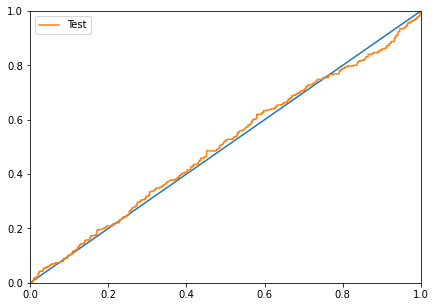

In [16]:
# #batch_size=128인 경우
# allele = 'phospho-B-15'
# model = EfficientNet.from_name(f'efficientnet-{allele}')
# #model = nn.DataParallel(model) #strict=False를 인자로 넣어주면 코드 돌아감 but 돌릴때마다 값이 달라짐
# model.load_state_dict(torch.load('/home/geonwon/Code/saved_model2/'
#                                          'Efficientnet_0_kernel_3_ms_only_same_ratio'
#                                          '/best_15.pth'
#                                          )['state_dict'],strict = False)
# model.eval()

# BATCH_SIZE = 128

# #test_set = data_utils.TensorDataset(torch.tensor(xTest,device='cuda:2'),torch.tensor(yTest,device='cuda:2'))
# test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
# test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= False)

    
# dataloaders = {'test':test_loader}
# dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
# model = test_model(model, optimizer, scheduler, 1) 

# plt.figure(figsize=[7,5])
# plt.plot([0,1],[0,1])
# plt.plot(fprs,tprs, label= 'Test')
# plt.legend()
# #plt.xlabel("False positive rate")
# #plt.ylabel("True positive rate")
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.show()

efficientnet-phospho-B-15
Testing on  4 GPUs!


  0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------------------------------
Epoch 1/1


  0%|          | 0/4 [00:00<?, ?it/s]

test Loss: 0.6931 Acc: 0.5252 F1: 0.5019 recall: 0.4997 AUC: 0.5029
------------------------------------------------------------

Test complete in 0m 0s
Best test Loss: 0.693140


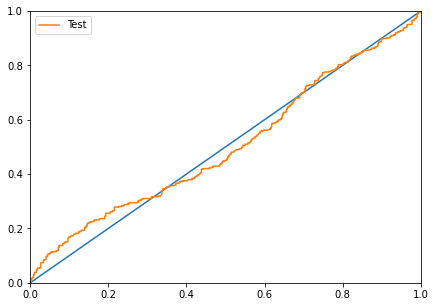

In [24]:
# #batch_size = 256인 경우
# allele = 'phospho-B-15'
# model = EfficientNet.from_name(f'efficientnet-{allele}')
# #model = nn.DataParallel(model)
# model.load_state_dict(torch.load('/home/geonwon/Code/saved_model4/'
#                                          'Efficientnet_0_kernel_3_ms_only_same_ratio'
#                                          '/best_30.pth'
#                                          )['state_dict'],strict = False)
# model.eval()

# BATCH_SIZE = 256

# #test_set = data_utils.TensorDataset(torch.tensor(xTest,device='cuda:2'),torch.tensor(yTest,device='cuda:2'))
# test_set = data_utils.TensorDataset(torch.tensor(xTest),torch.tensor(yTest))
# test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle= True)

    
# dataloaders = {'test':test_loader}
# dataset_sizes = {x: len(dataloaders[x]) for x in ['test']}
# model = test_model(model, optimizer, scheduler, 1) 

# plt.figure(figsize=[7,5])
# plt.plot([0,1],[0,1])
# plt.plot(fprs,tprs, label= 'Test')
# plt.legend()
# #plt.xlabel("False positive rate")
# #plt.ylabel("True positive rate")
# plt.xlim(0,1)
# plt.ylim(0,1)
# plt.show()